# Бейзлайн для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

In [59]:
pip install catboost


  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=ae48ba01a8dc80b2c4f84b248bb9be1e20efd95cc527e1f63f9b0c507950a45f
  Stored in directory: c:\users\администратор\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


Советы:
0. Заполнить аккаунт н Каггл: фото + статус Contributor
1. Сделайте стабильную валидацию
2. Тестируйте 1 изменение за раз
3. Не переусердствуйте с подбором гиперпараметров модели. Делайте это 1 раз вначале и 1 раз в конце
4. Прирост качества в основном зависит от __очистки данных__ и __генерации фич__, а не от модели
5. Бывает полезно удалить "мусорные" фичи. Определить их можно, например, через feature importance

Дедлайны и требования:
- Соревнование заказнчивается 29 апреля
- Необходимо получить R2 > 60% на __Private__ Leaderboard для успешного завершения курса
- Необходимо получить ранг "Contributor" в соревнованиях на Каггле: https://www.kaggle.com/progression
- Прислать в комментариях к ДЗ ссылка на решение проекта в git / public kaggle notebook

Переобучение

1. Большая разница между R2 на train и кросс-валидации
2. Большая разница между R2 на кросс-валидации и Public Leaderbord

In [1074]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor


%matplotlib inline

In [1075]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# 1. Чтение данных

In [1076]:
df = pd.read_csv('input/train.csv')


X = df.drop('Price', axis=1)
y = df[['Price']]


X_final = pd.read_csv('input/test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


17961

In [1077]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [1078]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. Минимальный EDA

Делайем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### 1.1 Выбросы

In [1079]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [1080]:
X['Helthcare_2'].value_counts()

# > 6 комнат, = 0 комнат

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [1081]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

In [1082]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [1083]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [1084]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [1085]:
X['HouseYear'].sort_values().unique()
X['Square'].sort_values()


Id
14786      1.136859
15744      1.988943
3224       2.377248
10202      2.596351
6782       2.954309
            ...    
7917     212.932361
5548     275.645284
2307     409.425181
28       604.705972
11602    641.065193
Name: Square, Length: 10000, dtype: float64

In [1086]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


### Заполнение NaN

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


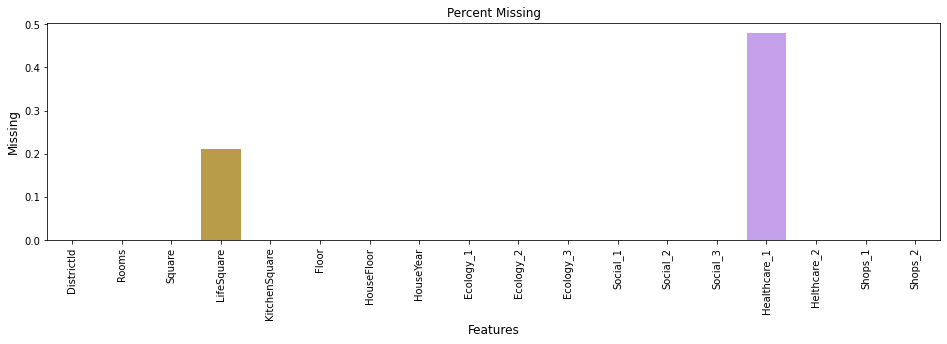

In [1087]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [1088]:
X.DistrictId.nunique()

205

In [1089]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '99': 97,
 '47': 97,
 '13': 97,
 '101': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '88': 64,
 '12': 64,
 '128': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '31': 55,
 '105': 55,
 '18': 51,
 '119': 49,
 '111': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '129': 43,
 '63': 43,
 '124': 43,
 '42': 42,
 '79': 42,
 '113': 41,
 '109': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '5': 34,
 '32': 34,
 '56': 34,
 '103': 33,
 '123': 32,
 '33': 31,
 '19': 31,
 '83': 31,
 '80': 31,
 '138': 29,
 '130': 29,
 '69': 29,
 '64': 28,
 '70': 27,
 '86': 27,
 '87': 27,
 '108': 

# 2. Очистка данных

In [1090]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
        
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] =  self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] >100, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        condition2 = (~X['LifeSquare'].isna()) & (~X['KitchenSquare'].isna())
        
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        X['RealSquare'] = 0
        X.loc[condition2, 'RealSquare'] =  X.loc[condition2, 'LifeSquare'] + X.loc[condition2, 'KitchenSquare']+3
        X.loc[X['RealSquare']==0,'RealSquare'] = X['RealSquare'].mean()
        
        
        
        
        
        
        return X
        

81.053044    1
54.002221    1
49.934561    1
53.317372    1
77.910891    1
            ..
57.134181    1
73.431719    1
46.049526    1
76.624790    1
97.664912    1
Name: Square, Length: 10000, dtype: int64

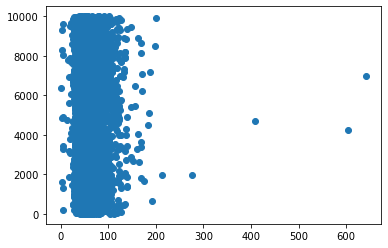

In [1091]:

imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

#X_final['RealSquare']
#plt.scatter(X['KitchenSquare'], [i for i in range(10000)]);
#plt.scatter(X['Ecology_1'], [i for i in range(10000)]);
plt.scatter(X['Square'], [i for i in range(10000)]);
X['Square'].value_counts()




#plt.xscale(value="log")

# 3. Feature engineering

In [1092]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None        
        self.med_price_by_social_1 = None
        self.med_price_by_shops_1 = None
        self.med_price_by_house_year = None
        self.med_price_by_ecology_1 = None
        self.med_price_by_floor_cat = None
        self.med_price_by_room = None
        self.med_price_by_kitchen_square = None
        self.med_price_by_helthcare_2 = None
        self.med_price_by_social_2 = None
        self.med_price_by_social_3 = None
        self.med_price_by_square_cat = None
        
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_social_1 = df.groupby(['Social_1', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial_1'})
            
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
            
            self.med_price_by_shops_1 = df.groupby(['Shops_1', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShops_1'})
            
            self.med_price_by_house_year = df.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHouseYear'})
            
            self.med_price_by_ecology_1 = df.groupby(['Ecology_1', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcology_1'})
            
            self.med_price_by_helthcare_2 = df.groupby(['Helthcare_2', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByHelthcare_2'})

            
            self.med_price_by_social_2 = df.groupby(['Social_2', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial_2'})
            
            self.med_price_by_social_3 = df.groupby(['Social_3', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial_3'})
            
            ## floor, year        
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.kitchen_to_cat(df)
            df = self.square_to_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
            self.med_price_by_floor_cat = df.groupby(['floor_cat','Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorCat'})
           
           
           
            self.med_price_by_kitchen_square = df.groupby(['kitchen_cat','Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByKitchenCat'})
            
            self.med_price_by_square_cat = df.groupby(['square_cat','Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareCat'})
            
            
            

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)   # + столбец floor_cat
        X = self.year_to_cat(X)    # + столбец year_cat
        X = self.kitchen_to_cat(X) # + столбец kitchen_cat
        X = self.square_to_cat(X)  # + столбец square_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_social_1 is not None:
            X = X.merge(self.med_price_by_social_1, on=['Social_1', 'Rooms'], how='left')
        if self.med_price_by_shops_1 is not None:
            X = X.merge(self.med_price_by_shops_1, on=['Shops_1', 'Rooms'], how='left')
        if self.med_price_by_house_year is not None:
            X = X.merge(self.med_price_by_house_year, on=['HouseYear', 'Rooms'], how='left')
        if self.med_price_by_ecology_1 is not None:
            X = X.merge(self.med_price_by_ecology_1, on=['Ecology_1', 'Rooms'], how='left')

        if self.med_price_by_floor_cat is not None:
            X = X.merge(self.med_price_by_floor_cat, on=['floor_cat', 'Rooms'], how='left')
        if self.med_price_by_kitchen_square is not None:
            X = X.merge(self.med_price_by_kitchen_square, on=['kitchen_cat', 'Rooms'], how='left')        
        if self.med_price_by_helthcare_2 is not None:
            X = X.merge(self.med_price_by_helthcare_2, on=['Helthcare_2', 'Rooms'], how='left')        
        if self.med_price_by_social_2 is not None:
            X = X.merge(self.med_price_by_social_2, on=['Social_2', 'Rooms'], how='left')
        if self.med_price_by_social_3 is not None:
            X = X.merge(self.med_price_by_social_3, on=['Social_3', 'Rooms'], how='left')
        if self.med_price_by_square_cat is not None:
            X = X.merge(self.med_price_by_square_cat, on=['square_cat', 'Rooms'], how='left')
        
        
        
        # Отношения всей площади к сумме жилой площади и площади кухни       
        X['Square_div'] = np.nan           
        X['Square_div'] = X['Square']/(X['KitchenSquare']+X['LifeSquare'])
        X['RealSquare'].fillna(X['RealSquare'].mean(), inplace=True)
        
        X['MedPriceByDistrict'].fillna(X['MedPriceByDistrict'].mean(), inplace=True) 
        X['MedPriceByFloorYear'].fillna(X['MedPriceByFloorYear'].mean(), inplace=True)
  
        
    # 'MedPriceBySocial_1', 'MedPriceByDistrictSquare'        
        X['MedPriceBySocial_1'].fillna(X['MedPriceBySocial_1'].mean(), inplace=True)
        X['MedPriceByShops_1'].fillna(X['MedPriceByShops_1'].mean(), inplace=True)
        X['MedPriceByHouseYear'].fillna(X['MedPriceByHouseYear'].mean(), inplace=True)
        
        X['MedPriceByHouseYear_MedPriceByFloorYear'] = X['MedPriceByHouseYear']/X['MedPriceByFloorYear']
        X['MedPriceByEcology_1'].fillna(X['MedPriceByEcology_1'].mean(), inplace=True)
        X['MedPriceBySocial_1_MedPriceByShops_1'] = X['MedPriceBySocial_1']/X['MedPriceByShops_1']
        X['Square_LifeSquare'] = X['Square']/X['LifeSquare']
        X['Square_DistrictId_count'] = X['Square']/X['DistrictId_count']
        X['RealSquare_DistrictId_count'] = X['RealSquare'].mean()/X['DistrictId_count'].mean()
        X.loc[X['Ecology_1']==0,'Ecology_1'] = X['Ecology_1'].mean()
        X['Social_1_Ecology'] = X['Social_1']/X['Ecology_1']
        
        X.loc[X['Shops_1']==0,'Shops_1'] = X['Shops_1'].mean()
        
        X['Social_1_Shops_1'] = X['Social_1']/X['Shops_1']
        X['Social_1_Shops_1'].fillna(X['Social_1_Shops_1'].mean(), inplace=True)        
        X['Floor_HouseFloor'] =  X['Floor']/X['HouseFloor']
        X['KitchenSquare_Square'] =  X['KitchenSquare']/X['Square']
        X['Rooms_DistrictId_count'] = X['Rooms']/X['DistrictId_count']
        X['Social_2_Social_1'] = X['Social_2']/X['Social_1']
        X['Social_3_Social_1'] = X['Social_3']/X['Social_1']
        X['Shops_2_Shops_1'] = X['Shops_2']/X['Shops_1']
        X['MedPriceBySocial_2_MedPriceBySocial_3'] = X['MedPriceBySocial_2']/X['MedPriceBySocial_3']
        X['KitchenSquare_Square_Rooms_DistrictId_count'] = X['KitchenSquare_Square']/X['Rooms_DistrictId_count']
        X['MedPriceBySocial_2'].fillna(X['MedPriceBySocial_2'].mean(), inplace=True)
        X['MedPriceBySocial_3'].fillna(X['MedPriceBySocial_3'].mean(), inplace=True)        
        X['MedPriceBySquareCat'].fillna(X['MedPriceBySquareCat'].mean(), inplace=True)
        X['Social_3_Social_1'].fillna(X['Social_3_Social_1'].mean(), inplace=True)
        X['MedPriceBySocial_2_MedPriceBySocial_3'].fillna(X['MedPriceBySocial_2_MedPriceBySocial_3'].mean(),inplace=True)
        
        
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
    
   
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
    
    @staticmethod
    def kitchen_to_cat(X):
        
        X['kitchen_cat'] = np.nan
        
        X.loc[(X['KitchenSquare'] >= 0) & (X['KitchenSquare'] <= 4),'kitchen_cat'] = 1
        X.loc[(X['KitchenSquare'] >= 5) & (X['KitchenSquare'] <= 9),'kitchen_cat'] = 2
        X.loc[(X['KitchenSquare'] >= 10) & (X['KitchenSquare'] <= 14),'kitchen_cat'] = 3
        X.loc[X['KitchenSquare'] >= 15,'kitchen_cat'] = 4
        
        return X
    
    @staticmethod
    def square_to_cat(X):
        
        X['square_cat'] = np.nan
        
        X.loc[(X['Square'] >= 0) & (X['Square'] < 30),'square_cat'] = 1
        X.loc[(X['Square'] >= 30) & (X['Square'] < 50),'square_cat'] = 2
        X.loc[(X['Square'] >= 50) & (X['Square'] < 70),'square_cat'] = 3
        X.loc[(X['Square'] >= 70) & (X['Square'] < 90),'square_cat'] = 4
        X.loc[(X['Square'] >= 90) & (X['Square'] < 120),'square_cat'] = 5        
        X.loc[X['Square'] >= 120,'square_cat'] = 6
        
        return X
    
            
    

In [1093]:
features = FeatureGenetator()


features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)
X_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 56 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   DistrictId                                   5000 non-null   object 
 1   Rooms                                        5000 non-null   float64
 2   Square                                       5000 non-null   float64
 3   LifeSquare                                   5000 non-null   float64
 4   KitchenSquare                                5000 non-null   float64
 5   Floor                                        5000 non-null   float64
 6   HouseFloor                                   5000 non-null   float64
 7   HouseYear                                    5000 non-null   int64  
 8   Ecology_1                                    5000 non-null   float64
 9   Ecology_2                                    5000 non-null   int64  
 10  

In [1094]:
#'MedPriceByDistrict','MedPriceByFloorYear','Ecology_2', 'Ecology_3', 'LifeSquare_nan','new_district', 'HouseFloor_outlier', 
#'Rooms', 'Rooms_outlier', 'Shops_2',
remain_features = ['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',                   
                   'HouseFloor', 'HouseYear',                   
                  'DistrictId_count',  'RealSquare', 'Square_div', 
                   'MedPriceBySocial_1', 'MedPriceByShops_1',                 
                   'MedPriceByHouseYear', 'MedPriceBySocial_1_MedPriceByShops_1',
                   'MedPriceByEcology_1',
                   'Shops_2', 'Square_LifeSquare', 'Social_1_Ecology', 'Social_1_Shops_1', 'Floor_HouseFloor',
                   'KitchenSquare_Square', 'MedPriceByFloorCat', 'MedPriceByKitchenCat',
                   'Ecology_2', 'Ecology_3', 'LifeSquare_nan', 'HouseFloor_outlier', 
                    'Helthcare_2','MedPriceByHelthcare_2','Rooms_DistrictId_count',
                   'MedPriceByDistrict', 'MedPriceBySocial_2', 'MedPriceBySocial_3',
                   'Social_2_Social_1', 'Social_3_Social_1','Shops_2_Shops_1',
                   'MedPriceBySquareCat', 'square_cat', 'MedPriceBySocial_2_MedPriceBySocial_3',
                   'KitchenSquare_Square_Rooms_DistrictId_count','Rooms', 'kitchen_cat'
                  ]



X_t = X.copy()
X_t = X_t[remain_features2]
X = X[remain_features]
X_final = X_final[remain_features]






# 4. Модель

In [1095]:
model = LGBMRegressor(max_depth=6,   num_leaves=14,  n_estimators=400, random_state=46)


cv_score = cross_val_score(model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.4f} +- {:.3f}'.format(mean, std))



def test_reg(X, y, n, num_leaves, n_es):
    model = LGBMRegressor(max_depth=n,
                             num_leaves=num_leaves,
                             n_estimators=n_es,
                             random_state=46)


    return model
 
#print('R2: {:.4f} +- {:.3f}'.format(mean, std))

#b_list =[(6,12,400), (7,10,300), (7,12,400), (6,14,400), (6,15,500), (6,10,300)]
#for n, num_leaves, n_es in b_list:
#    print(n, num_leaves, n_es)
#    model = test_reg(X, y, n, num_leaves, n_es)
#    cv_score = cross_val_score(model, X, y, 
#                               scoring='r2', 
#                               cv=KFold(n_splits=5, shuffle=True, random_state=42))
#    # cv_score
#    mean = cv_score.mean()
#    std = cv_score.std()
#    print('R2: {:.4f} +- {:.3f}'.format(mean, std))


R2: 0.7500 +- 0.022


In [1096]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(max_depth=6, n_estimators=400, num_leaves=14, random_state=46)

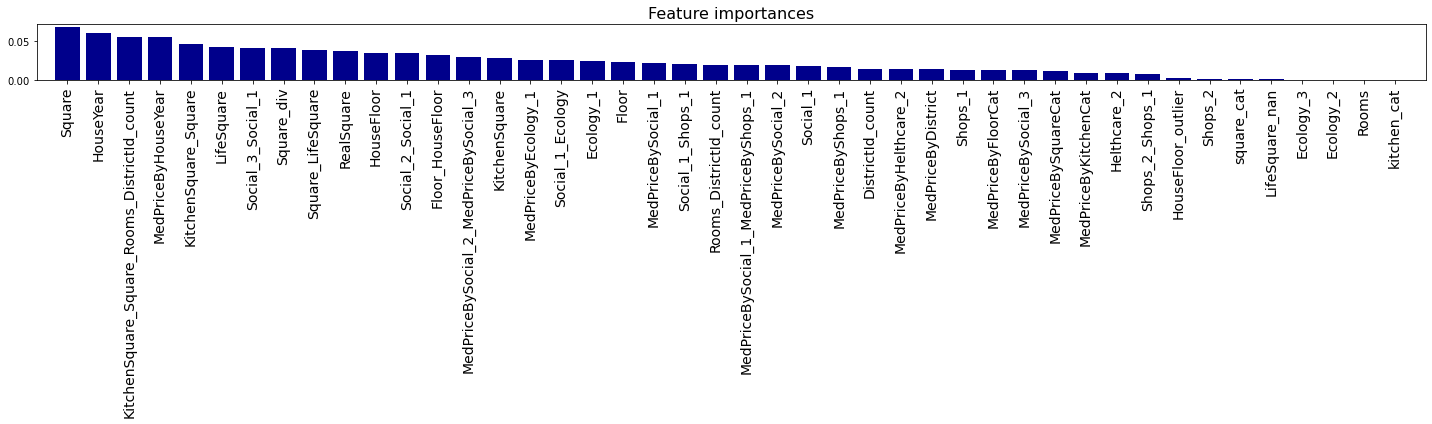

In [1097]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [1098]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,156325.870061
1,15856,220046.146441
2,5480,318518.399628
3,15664,370821.307103
4,14275,144912.479351
